In [107]:
import sqlite3
import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

## Find/Decide Cluster Representatives by calculation center for each cluster

In [112]:
def load_dataframe():
    con = sqlite3.connect("../data/global_urban_building_completeness.gpkg")
    query = f"""
        select 
            urban_center_id
            ,osm_completeness
            ,gini
            ,moran
            ,label
            ,cluster
        from inequality_measures_urban_centers
        order by urban_center_id
    """
    df = pd.read_sql_query(query, con=con)
    df.dropna(inplace=True)
    return df

def calc_distance(row, cluster_center):
    distance = math.dist(
        cluster_center,
        [
            row["osm_completeness"],
            row["gini"],
            row["moran"]
        ]
    )
    return distance


def load_urban_centers_with_name():
    """Load urban center grids for given urban center id."""
    con = sqlite3.connect("../data/global_urban_building_completeness.gpkg")
    query = f"""
        select 
          urban_center_id,
          name_main,
          iso_a3,
          ghspop_2020 / 1000000.0 as ghspop
        from rf_adjusted_prediction_reference_and_osm_urban_centers a
        group by urban_center_id
    """
    df = pd.read_sql_query(query, con=con)
    return df

In [113]:
df = load_dataframe()

cluster_labels = [
    "a", "b", "c", "d", "e"
]

urban_centers_df = load_urban_centers_with_name().set_index("urban_center_id")

for i, label in enumerate(cluster_labels):
    
    print(label, cluster_labels[i])
    cluster_df = df.loc[df["cluster"] == cluster_labels[i]]
    cluster_center = [
        cluster_df["osm_completeness"].mean(),
        cluster_df["gini"].mean(),
        cluster_df["moran"].mean()
    ]
    
    cluster_df["distance"] = cluster_df.apply(lambda row: calc_distance(row, cluster_center),axis=1)  
    cluster_df.set_index("urban_center_id", inplace=True)
    
    cluster_df = cluster_df.join(urban_centers_df)
    
    display(
        cluster_df.loc[cluster_df["ghspop"]>1.5].sort_values(by="distance", ascending=True)[0:15]
    )

a a


/tmp/ipykernel_156053/812240108.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["distance"] = cluster_df.apply(lambda row: calc_distance(row, cluster_center),axis=1)


,osm_completeness,gini,moran,label,cluster,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,
7106,0.017,0.896,0.076,3,a,0.057475,Meerut,IND,1.753559
6518,0.014,0.829,0.059,3,a,0.061972,Sialkot,PAK,1.744801
9459,0.011,0.901,0.088,3,a,0.071077,Asansol,IND,2.876512
6445,0.017,0.907,0.096,3,a,0.079977,Faisalabad,PAK,4.307384
6779,0.024,0.812,0.071,3,a,0.082296,Vadodara,IND,1.994787
12535,0.006,0.942,0.083,3,a,0.090149,Cixi,CHN,2.138181
7308,0.021,0.776,0.049,3,a,0.105451,Agra,IND,2.318532
9416,0.039,0.907,0.126,3,a,0.109660,Jamshedpur,IND,1.625039
6510,0.012,0.868,0.141,3,a,0.120128,Gujranwala,PAK,2.765636


b b


/tmp/ipykernel_156053/812240108.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["distance"] = cluster_df.apply(lambda row: calc_distance(row, cluster_center),axis=1)


,osm_completeness,gini,moran,label,cluster,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,
5865,0.144,0.688,0.259,1,b,0.042098,Manama,BHR,1.551422
10533,0.087,0.724,0.203,1,b,0.056700,Kunming,CHN,3.158744
514,0.083,0.727,0.283,1,b,0.062878,Cali,COL,2.420502
5948,0.083,0.763,0.266,1,b,0.066265,Mashhad,IRN,2.205677
854,0.081,0.680,0.271,1,b,0.071423,El Alto [La Paz],BOL,1.715305
12703,0.156,0.692,0.179,1,b,0.073997,Daegu,KOR,2.283555
10664,0.127,0.763,0.304,1,b,0.074940,Chongqing,CHN,3.832203
429,0.089,0.724,0.309,1,b,0.079336,Guayaquil,ECU,2.813948
10323,0.053,0.713,0.264,1,b,0.080440,Hohhot,CHN,2.023050


c c


/tmp/ipykernel_156053/812240108.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["distance"] = cluster_df.apply(lambda row: calc_distance(row, cluster_center),axis=1)


,osm_completeness,gini,moran,label,cluster,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,
10920,0.293,0.801,0.603,4,c,0.048206,Luoyang,CHN,1.729774
746,0.318,0.798,0.651,4,c,0.050242,Port-au-Prince,HTI,1.887883
1805,0.350,0.812,0.664,4,c,0.072349,Ouagadougou,BFA,2.155782
1602,0.364,0.838,0.659,4,c,0.080203,Rabat,MAR,2.005272
2494,0.233,0.864,0.702,4,c,0.089561,Onitsha,NGA,3.043621
13076,0.369,0.837,0.594,4,c,0.092495,Melbourne,AUS,3.506565
1912,0.202,0.847,0.590,4,c,0.097769,Accra,GHA,4.531411
12270,0.187,0.855,0.645,4,c,0.102341,Zhuhai,CHN,1.865648
250,0.365,0.774,0.676,4,c,0.106445,San Antonio,USA,1.759682


d d


/tmp/ipykernel_156053/812240108.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["distance"] = cluster_df.apply(lambda row: calc_distance(row, cluster_center),axis=1)


,osm_completeness,gini,moran,label,cluster,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,
3821,0.668,0.685,0.551,2,d,0.078670,Ankara,TUR,2.693571
1079,0.733,0.785,0.507,2,d,0.079553,Asuncion,PRY,1.662691
1708,0.679,0.722,0.420,2,d,0.086293,Madrid,ESP,5.490536
2059,0.656,0.839,0.470,2,d,0.098502,Barcelona,ESP,4.341327
474,0.587,0.745,0.570,2,d,0.102977,Havana,CUB,1.803239
1682,0.706,0.798,0.582,2,d,0.104683,Abidjan,CIV,5.025988
1532,0.748,0.684,0.517,2,d,0.105645,Monrovia,LBR,1.565640
3454,0.734,0.683,0.554,2,d,0.107902,Bucharest,ROU,1.806537
6887,0.571,0.687,0.511,2,d,0.110446,Mumbai,IND,21.307514


e e


/tmp/ipykernel_156053/812240108.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["distance"] = cluster_df.apply(lambda row: calc_distance(row, cluster_center),axis=1)


,osm_completeness,gini,moran,label,cluster,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,
2054,0.953,0.681,0.152,0,e,0.075902,Paris,FRA,9.939910
2320,0.923,0.609,0.147,0,e,0.077250,Cologne,DEU,1.584405
3228,0.945,0.758,0.163,0,e,0.111733,Warsaw,POL,1.796300
3686,0.936,0.759,0.215,0,e,0.130905,Moscow,RUS,14.440212
2285,0.924,0.650,0.257,0,e,0.131316,Dortmund,DEU,3.453502
629,0.921,0.553,0.061,0,e,0.146162,Barranquilla,COL,2.060082
2792,0.972,0.796,0.121,0,e,0.155532,Munich,DEU,1.678588
2907,0.895,0.498,0.176,0,e,0.179137,Rome,ITA,2.383613
2542,0.942,0.802,0.269,0,e,0.196759,Hamburg,DEU,1.546290


The following urban centers have been selected:
* "A - Faisalabad",
* "B - El Alto (La Paz),
* "C - Accra",
* "D - Montreal",
* "E - Paris", 

### Plot Scatterplots (for Figure 5)

/tmp/ipykernel_156053/2720733911.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i])


,urban_center_id,osm_completeness,gini,moran,label,cluster
2368,6445,0.017,0.907,0.096,3,a


,urban_center_id,osm_completeness,gini,moran,label,cluster
2368,6445,0.017,0.907,0.096,3,a


/tmp/ipykernel_156053/2720733911.py:107: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i + n_clusters])
/tmp/ipykernel_156053/2720733911.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i])


,urban_center_id,osm_completeness,gini,moran,label,cluster
495,854,0.081,0.68,0.271,1,b


,urban_center_id,osm_completeness,gini,moran,label,cluster
495,854,0.081,0.68,0.271,1,b


/tmp/ipykernel_156053/2720733911.py:107: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i + n_clusters])
/tmp/ipykernel_156053/2720733911.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i])


,urban_center_id,osm_completeness,gini,moran,label,cluster
1014,1912,0.202,0.847,0.59,4,c


,urban_center_id,osm_completeness,gini,moran,label,cluster
1014,1912,0.202,0.847,0.59,4,c


/tmp/ipykernel_156053/2720733911.py:107: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i + n_clusters])
/tmp/ipykernel_156053/2720733911.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i])


,urban_center_id,osm_completeness,gini,moran,label,cluster
613,1022,0.548,0.816,0.499,2,d


,urban_center_id,osm_completeness,gini,moran,label,cluster
613,1022,0.548,0.816,0.499,2,d


/tmp/ipykernel_156053/2720733911.py:107: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i + n_clusters])
/tmp/ipykernel_156053/2720733911.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i])


,urban_center_id,osm_completeness,gini,moran,label,cluster
1072,2054,0.953,0.681,0.152,0,e


,urban_center_id,osm_completeness,gini,moran,label,cluster
1072,2054,0.953,0.681,0.152,0,e


/tmp/ipykernel_156053/2720733911.py:107: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[i + n_clusters])


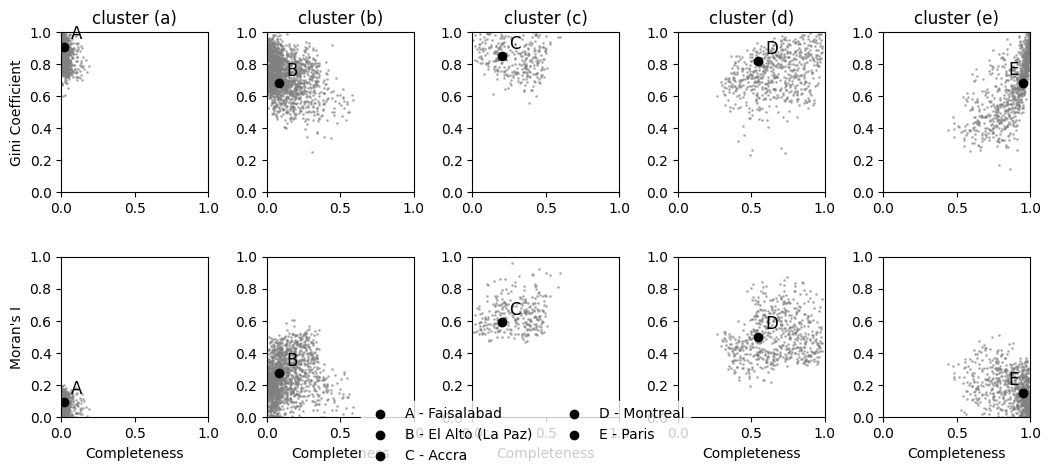

In [114]:
urban_center_ids_selection = [
    6445,  # Faisalabad
    854, # El Alto (La Paz)
    1912,  # Accra
    1022,  # Montreal
    2054  # Paris
]   


colors = [
    "green",
    "blue",
    "black",
    "orange",
    "violet",
    "red"
]

title_labels = [
    "cluster (a)", "cluster (b)", "cluster (c)", "cluster (d)", "cluster (e)"
]

cluster_labels = [
    "a", "b", "c", "d", "e"
]


point_labels_names = [
    "A - Faisalabad",
    "B - El Alto (La Paz)",
    "C - Accra",
    "D - Montreal",
    "E - Paris",
]

point_labels = [
    "A",
    "B",
    "C",
    "D",
    "E",
]
size= 12

fig, axs = plt.subplots(2, n_clusters, figsize=(12.5, 5))
gs1 = gridspec.GridSpec(2, n_clusters)
gs1.update(wspace=0.4, hspace=0.4) # set the spacing between axes.

all_handles = []
all_labels = []

for i in range(0, n_clusters):
    # ax = plt.subplot(gs1[3*i])
    ax = plt.subplot(gs1[i])
    cluster_df = df.loc[df["cluster"] == cluster_labels[i]]

    cluster_df_selection = cluster_df.loc[cluster_df["urban_center_id"].isin(urban_center_ids_selection)]
    
    display(cluster_df_selection)
    
    display(cluster_df_selection)
    
    ax.scatter(
        cluster_df["osm_completeness"],
        cluster_df["gini"],
        #color=colors[i],
        color="grey",
        s=1,
        alpha=0.5
    )
    
    ax.scatter(
        cluster_df_selection["osm_completeness"],
        cluster_df_selection["gini"],
        #color=colors[i],
        color="black",
        alpha=1,
        label=point_labels_names[i]
    )
    
    
    if cluster_df_selection["osm_completeness"].to_list()[0] > 0.9:
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] - 0.1,
             cluster_df_selection["gini"].to_list()[0] + 0.05),
            fontsize=size
        ) 
    else:
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] + 0.05,
             cluster_df_selection["gini"].to_list()[0] + 0.05),
            fontsize=size
        )
    
    
    # ax.set_xlabel("Completeness")
    if i == 0:
        ax.set_ylabel("Gini Coefficient")
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    ax.set_title(title_labels[i])
    #ax.grid()
    
    # ax = plt.subplot(gs1[1 + 3*i])
    ax = plt.subplot(gs1[i + n_clusters])
    ax.scatter(
        cluster_df["osm_completeness"],
        cluster_df["moran"],
        #color=colors[i],
        color="grey",
        s=1,
        alpha=0.5
    )
    
    
    if cluster_df_selection["osm_completeness"].to_list()[0] > 0.9:
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] - 0.1,
             cluster_df_selection["moran"].to_list()[0] + 0.05),
            fontsize=size
        )
        ax.scatter(
            cluster_df_selection["osm_completeness"],
            cluster_df_selection["moran"].to_list()[0],
            #color=colors[i],
            color="black",
            alpha=1,
            label=point_labels_names[i]
        )
    else:
        ax.scatter(
            cluster_df_selection["osm_completeness"],
            cluster_df_selection["moran"],
            #color=colors[i],
            color="black",
            alpha=1,
            label=point_labels_names[i]
        )
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] + 0.05,
             cluster_df_selection["moran"].to_list()[0] + 0.05),
            fontsize=size
        )
   
    ax.set_xlabel("Completeness")
    if i == 0:
        ax.set_ylabel("Moran's I")
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    #ax.grid()

    handles, labels = ax.get_legend_handles_labels()
    all_handles.append(handles[0])
    all_labels.append(labels[0])
    
fig.legend(
    all_handles,
    all_labels,
    loc='lower center',
    ncol=2,
    edgecolor="white"
)    

plt.savefig(
    "../figures/intra_urban_completeness_clustering_plot.png",
    dpi=300,
    bbox_inches = 'tight',
    pad_inches = 0.75
)
plt.show()

### Plot Cluster Dendogram (for Figure 6)

[4232 4526 3074 ...    6    2    0]


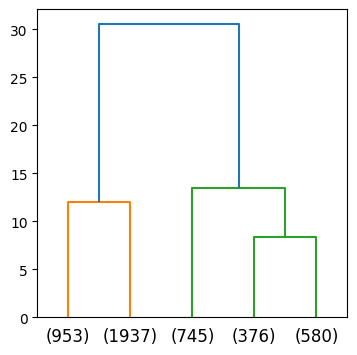

[4232 4526 3074 ...    6    2    0]


In [115]:
def run_clustering_full(X):
    cluster = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=0
    )
    cluster.fit(X)
    
    print(cluster.labels_)
    return cluster


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

cluster2 = run_clustering_full(X)

plt.figure(figsize=(4,4))
# plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(
    cluster2,
    truncate_mode='lastp',
    p=5,
)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig(
    "../figures/intra_urban_completeness_cluster_dendrogram.png",
    dpi=300,
    bbox_inches = 'tight'
)
plt.show()


print(cluster2.labels_)

## Evaluate cluster metrics for different number clusters

### Silhouette Coefficient
If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class
- b: The mean distance between a sample and all other points in the next nearest cluster.



### calinski harabasz
If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)

(source: https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)

In [117]:
from sklearn import metrics

n_clusters = 5
columns = [
    "osm_completeness",
    "gini",
    "moran"
]

stats_df_cluster_test = df.dropna()
X = stats_df_cluster_test[columns].values

scores_list = []

for i in range(2, 9):
    cluster = AgglomerativeClustering(n_clusters=i).fit(X)
    s_score = metrics.silhouette_score(X, cluster.labels_, metric='euclidean')
    ch_score = metrics.calinski_harabasz_score(X,  cluster.labels_)
    
    scores_list.append([
        i,
        s_score,
        ch_score,
    ])

columns = [
    "n_clusters",
    "silhouette_score",
    "calinski_harabasz_score",
]
display(pd.DataFrame(scores_list, columns=columns))
    

,n_clusters,silhouette_score,calinski_harabasz_score
0,2,0.496177,5242.897206
1,3,0.471266,4964.322646
2,4,0.331393,4487.652782
3,5,0.309064,4167.535772
4,6,0.308807,4029.815363
5,7,0.321195,4052.337743
6,8,0.323455,3940.879094
